<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-6/Instacart_2017_XGBoost_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
products = pd.read_csv("products.csv")
# orders = pd.read_csv("orders_50.csv")
# order_products_prior = pd.read_csv("op_prior_50.csv")
# order_products_train = pd.read_csv("op_train_50.csv")
orders = pd.read_csv("orders_100.csv")
order_products_prior = pd.read_csv("op_prior_100.csv")
order_products_train = pd.read_csv("op_train_100.csv")
# orders = pd.read_csv("orders.csv")
# order_products_prior = pd.read_csv("order_products__prior.csv")
# order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (1665732, 7)
products:  (49688, 4)
order_products_prior:  (15806241, 4)
order_products_train:  (672294, 4)


Reducing size of orders for faster computation

In [3]:
# orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(1665732, 7)

In [4]:
orders.head(11)
orders[(orders['eval_set']=='train') & (orders['user_id']==1)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0


Changing some columns from object type to Category

In [5]:
order_products_train[order_products_train['order_id']==1187899]

,order_id,product_id,add_to_cart_order,reordered
235451,1187899,196,1,1
235452,1187899,25133,2,1
235453,1187899,38928,3,1
235454,1187899,26405,4,1
235455,1187899,39657,5,1
235456,1187899,10258,6,1
235457,1187899,13032,7,1
235458,1187899,26088,8,1
235459,1187899,27845,9,0
235460,1187899,49235,10,1


In [6]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [7]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (15806241, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [8]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15806241 entries, 0 to 15806240
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
dtypes: category(1), float64(1), int64(8)
memory usage: 1.2 GB


In [9]:
op['reordered'] = op['reordered'].astype('int8')
op['order_dow'] = op['order_dow'].astype('int8')
op['order_hour_of_day'] = op['order_hour_of_day'].astype('int8')
op['add_to_cart_order'] = op['add_to_cart_order'].astype('int8')
op['days_since_prior_order'] = op['days_since_prior_order'].astype('float16')
op['user_id'] = op['user_id'].astype('int32')
op['order_id'] = op['order_id'].astype('int32')

In [10]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15806241 entries, 0 to 15806240
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int64   
 8   add_to_cart_order       int8    
 9   reordered               int8    
dtypes: category(1), float16(1), int32(2), int64(2), int8(4)
memory usage: 587.9 MB


1. USER PREDICTORS




In [11]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (99999, 1)
total users in the prior dataset = 99999


,u_total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [12]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [13]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (99999, 2)


,user_id,u_reordered_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [14]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (99999, 3)


,user_id,u_total_orders,u_reordered_ratio
0,1,10,0.694915
1,2,14,0.476923
2,3,12,0.625000
3,4,5,0.055556
4,5,4,0.378378


2. PRODUCT PREDICTORS

In [15]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 2)


,product_id,p_total_purchases
0,1,919
1,2,58
2,3,149
3,4,158
4,5,2


In [16]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (13952977, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [17]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (7936, 2)


,product_id,p_reorder_ratio
0,1,0.610446
1,10,0.516541
2,23,0.440882
3,25,0.641077
4,28,0.462236


In [18]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (49096, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,919,0.610446
1,2,58,NaN
2,3,149,NaN
3,4,158,NaN
4,5,2,NaN


In [19]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,919,0.610446
1,2,58,0.000000
2,3,149,0.000000
3,4,158,0.000000
4,5,2,0.000000


3. USER-PRODUCT PREDICTORS

In [20]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
1       196                       10
        10258                      9
        10326                      1
        12427                     10
        13032                      3

In [21]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 3)


,user_id,product_id,uxp_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [22]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (6479328, 1)


Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [23]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (99999, 2)


,user_id,total_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [24]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (6479328, 3)


,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [25]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 4)


,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [26]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (6479328, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [27]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [28]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [29]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (6479328, 3)


,user_id,product_id,uxp_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [30]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [31]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (6479328, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


MERGE ALL FEATURES

In [32]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,1,196,10,1.000000,10,0.694915
1,1,10258,9,1.000000,10,0.694915
2,1,10326,1,0.166667,10,0.694915
3,1,12427,10,1.000000,10,0.694915
4,1,13032,3,0.333333,10,0.694915


In [33]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (6479328, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,196,10,1.000000,10,0.694915,17589,0.778384
1,1,10258,9,1.000000,10,0.694915,865,0.702890
2,1,10326,1,0.166667,10,0.694915,2743,0.656945
3,1,12427,10,1.000000,10,0.694915,3092,0.736740
4,1,13032,3,0.333333,10,0.694915,1670,0.636527


In [34]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

50

TRAIN DF

In [35]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (1665732, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [36]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op.head(10)

op.shape = (15806241, 10)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,NaN,196,0
1,1,1,2,8,NaN,14084,0
2,1,1,2,8,NaN,12427,0
3,1,1,2,8,NaN,26088,0
4,1,1,2,8,NaN,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [37]:
op['days_since_prior_order'] = op['days_since_prior_order'].fillna(0)
op.head(30)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,1,2,8,0.0,196,0
1,1,1,2,8,0.0,14084,0
2,1,1,2,8,0.0,12427,0
3,1,1,2,8,0.0,26088,0
4,1,1,2,8,0.0,26405,0
5,1,2,3,7,15.0,196,1
6,1,2,3,7,15.0,10258,0
7,1,2,3,7,15.0,12427,1
8,1,2,3,7,15.0,13176,0
9,1,2,3,7,15.0,26088,1


In [38]:
# op = op.groupby(['user_id','product_id'])['reordered'].sum()

# op = op.reset_index()
# # op3 = op3[op3['new_reorder'] > 0]

# # new_reorder = np.where(op3["new_reorder"] > 0, 1, 0)
# op['reordered'] = op['reordered'].apply(lambda x: 0 if x == 0 else 1)
# op.head(20)
# op.shape

In [39]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (15806241, 13)


In [40]:
del op

In [41]:
opjoin.head(40)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,1,2,8,0.0,196,0,10,1.000000,10,0.694915,17589,0.778384
1,1,1,2,8,0.0,14084,0,1,0.100000,10,0.694915,7973,0.810235
2,1,1,2,8,0.0,12427,0,10,1.000000,10,0.694915,3092,0.736740
3,1,1,2,8,0.0,26088,0,2,0.200000,10,0.694915,1260,0.538889
4,1,1,2,8,0.0,26405,0,2,0.200000,10,0.694915,544,0.411765
5,1,2,3,7,15.0,196,1,10,1.000000,10,0.694915,17589,0.778384
6,1,2,3,7,15.0,10258,0,9,1.000000,10,0.694915,865,0.702890
7,1,2,3,7,15.0,12427,1,10,1.000000,10,0.694915,3092,0.736740
8,1,2,3,7,15.0,13176,0,2,0.222222,10,0.694915,184594,0.832709
9,1,2,3,7,15.0,26088,1,2,0.200000,10,0.694915,1260,0.538889


In [42]:
opjoin['reordered'].unique()

array([0, 1], dtype=int8)

In [43]:
opjoin = opjoin.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [44]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head(11)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   

                    days_since_prior_order  reordered  uxp_reorder_ratio  \
user_id product_id                                                         
1       196                            0.0          0           1.000000   
        14084                          0.0          0           0.100000   
        12427                          0.0          0           1.000000   
        26088                          0.0          0           0.200000   
        26405                          0.0          0           0.200000   
        196                           15.0          1           1.000000   
        10258                         15.0          0           1.000000   
        12427                         15.0          1           1.000000   
        13176                         15.0          0           0.222222   
        26088                         15.0          1           0.200000   
        13032                         15.0          0           0.333333   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.778384  
        14084                0.694915         0.810235  
        12427                0.694915         0.736740  
        26088                0.694915         0.538889  
        26405                0.694915         0.411765  
        196                  0.694915         0.778384  
        10258                0.694915         0.702890  
        12427                0.694915         0.736740  
        13176                0.694915         0.832709  
        26088                0.694915         0.538889  
        13032                0.694915         0.636527

In [45]:
opjoin = opjoin.drop(['uxp_reorder_ratio', 'u_reordered_ratio', 'p_reorder_ratio'], axis=1)

In [46]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15806241 entries, (1, 196) to (99999, 23719)
Data columns (total 5 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_number            int64  
 1   order_dow               int8   
 2   order_hour_of_day       int8   
 3   days_since_prior_order  float16
 4   reordered               int8   
dtypes: float16(1), int64(1), int8(3)
memory usage: 320.7 MB


In [47]:
opjoin.head(20)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   
        196                    2          3                  7   
        10258                  2          3                  7   
        12427                  2          3                  7   
        13176                  2          3                  7   
        26088                  2          3                  7   
        13032                  2          3                  7   
        196                    3          3                 12   
        12427                  3          3                 12   
        10258                  3          3                 12   
        25133                  3          3                 12   
        30450                  3          3                 12   
        196                    4          4                  7   
        12427                  4          4                  7   
        10258                  4          4                  7   
        25133                  4          4                  7   

                    days_since_prior_order  reordered  
user_id product_id                                     
1       196                            0.0          0  
        14084                          0.0          0  
        12427                          0.0          0  
        26088                          0.0          0  
        26405                          0.0          0  
        196                           15.0          1  
        10258                         15.0          0  
        12427                         15.0          1  
        13176                         15.0          0  
        26088                         15.0          1  
        13032                         15.0          0  
        196                           21.0          1  
        12427                         21.0          1  
        10258                         21.0          1  
        25133                         21.0          0  
        30450                         21.0          0  
        196                           29.0          1  
        12427                         29.0          1  
        10258                         29.0          1  
        25133                         29.0          1

TEST DF 

In [48]:
order_products_train = order_products_train[order_products_train['reordered']==1]
print('order_products_train.shape =', order_products_train)
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head(20)

order_products_train.shape =         order_id  product_id  add_to_cart_order  reordered
1             36       19660                  2          1
3             36       43086                  4          1
4             36       46620                  5          1
5             36       34497                  6          1
6             36       48679                  7          1
...          ...         ...                ...        ...
672286   3420996       27423                  9          1
672287   3420996       12125                 10          1
672289   3421056        5750                  1          1
672290   3421056        9340                  2          1
672291   3421056       21709                  3          1

[403449 rows x 4 columns]
op_test.shape (403449, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1187899,1,train,11,4,8,14.0,196,1,1
1,1187899,1,train,11,4,8,14.0,25133,2,1
2,1187899,1,train,11,4,8,14.0,38928,3,1
3,1187899,1,train,11,4,8,14.0,26405,4,1
4,1187899,1,train,11,4,8,14.0,39657,5,1
5,1187899,1,train,11,4,8,14.0,10258,6,1
6,1187899,1,train,11,4,8,14.0,13032,7,1
7,1187899,1,train,11,4,8,14.0,26088,8,1
8,1187899,1,train,11,4,8,14.0,49235,10,1
9,1187899,1,train,11,4,8,14.0,46149,11,1


In [49]:
op_test = op_test.drop(['eval_set', 'order_id', 'add_to_cart_order'], axis=1)
op_test.head(15)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1
5,1,11,4,8,14.0,10258,1
6,1,11,4,8,14.0,13032,1
7,1,11,4,8,14.0,26088,1
8,1,11,4,8,14.0,49235,1
9,1,11,4,8,14.0,46149,1


In [50]:
op_test[op_test['user_id']==1]

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1
5,1,11,4,8,14.0,10258,1
6,1,11,4,8,14.0,13032,1
7,1,11,4,8,14.0,26088,1
8,1,11,4,8,14.0,49235,1
9,1,11,4,8,14.0,46149,1


In [51]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (403449, 7)


,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,expected_y
0,1,11,4,8,14.0,196,1
1,1,11,4,8,14.0,25133,1
2,1,11,4,8,14.0,38928,1
3,1,11,4,8,14.0,26405,1
4,1,11,4,8,14.0,39657,1


In [52]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (403449, 13)


In [53]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head(12)

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,1,11,4,8,14.0,196,10,1.000000,10,0.694915,17589,0.778384
1,1,11,4,8,14.0,25133,8,1.000000,10,0.694915,3003,0.732268
2,1,11,4,8,14.0,38928,1,1.000000,10,0.694915,6256,0.821132
3,1,11,4,8,14.0,26405,2,0.200000,10,0.694915,544,0.411765
4,1,11,4,8,14.0,39657,1,1.000000,10,0.694915,2424,0.768564
5,1,11,4,8,14.0,10258,9,1.000000,10,0.694915,865,0.702890
6,1,11,4,8,14.0,13032,3,0.333333,10,0.694915,1670,0.636527
7,1,11,4,8,14.0,26088,2,0.200000,10,0.694915,1260,0.538889
8,1,11,4,8,14.0,49235,2,0.666667,10,0.694915,35576,0.776113
9,1,11,4,8,14.0,46149,3,1.000000,10,0.694915,4188,0.815186


In [54]:
opjoin_test = opjoin_test.drop(['uxp_total_bought', 'u_total_orders', 'p_total_purchases'], axis=1)

In [55]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        25133                 11          4                  8   
        38928                 11          4                  8   
        26405                 11          4                  8   
        39657                 11          4                  8   

                    days_since_prior_order  uxp_reorder_ratio  \
user_id product_id                                              
1       196                           14.0                1.0   
        25133                         14.0                1.0   
        38928                         14.0                1.0   
        26405                         14.0                0.2   
        39657                         14.0                1.0   

                    u_reordered_ratio  p_reorder_ratio  
user_id product_id                                      
1       196                  0.694915         0.778384  
        25133                0.694915         0.732268  
        38928                0.694915         0.821132  
        26405                0.694915         0.411765  
        39657                0.694915         0.768564

In [56]:
opjoin_test = opjoin_test.drop(['uxp_reorder_ratio', 'u_reordered_ratio', 'p_reorder_ratio'], axis=1)
opjoin_test.head(15)

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        25133                 11          4                  8   
        38928                 11          4                  8   
        26405                 11          4                  8   
        39657                 11          4                  8   
        10258                 11          4                  8   
        13032                 11          4                  8   
        26088                 11          4                  8   
        49235                 11          4                  8   
        46149                 11          4                  8   
2       22963                 15          1                 11   
        7963                  15          1                 11   
        16589                 15          1                 11   
        32792                 15          1                 11   
        41787                 15          1                 11   

                    days_since_prior_order  
user_id product_id                          
1       196                           14.0  
        25133                         14.0  
        38928                         14.0  
        26405                         14.0  
        39657                         14.0  
        10258                         14.0  
        13032                         14.0  
        26088                         14.0  
        49235                         14.0  
        46149                         14.0  
2       22963                         30.0  
        7963                          30.0  
        16589                         30.0  
        32792                         30.0  
        41787                         30.0

Build Model

In [57]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [58]:
opjoin.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                    1          2                  8   
        14084                  1          2                  8   
        12427                  1          2                  8   
        26088                  1          2                  8   
        26405                  1          2                  8   

                    days_since_prior_order  reordered  
user_id product_id                                     
1       196                            0.0          0  
        14084                          0.0          0  
        12427                          0.0          0  
        26088                          0.0          0  
        26405                          0.0          0

In [59]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[20:23:25] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.690514
[10]	train-logloss:0.598307
[20]	train-logloss:0.566835
[30]	train-logloss:0.562865
[40]	train-logloss:0.562469
[50]	train-logloss:0.562385
[60]	train-logloss:0.562384
[70]	train-logloss:0.562453
[79]	train-logloss:0.562501


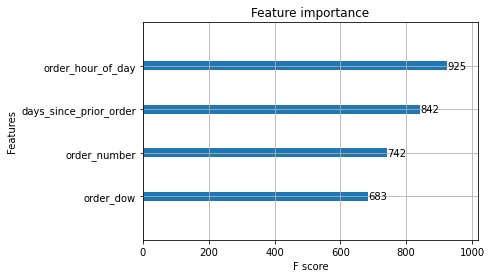

In [60]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [61]:
del [X_train, X_val, y_train, y_val]
gc.collect()

50

In [62]:
opjoin_test.head()

order_number  order_dow  order_hour_of_day  \
user_id product_id                                               
1       196                   11          4                  8   
        25133                 11          4                  8   
        38928                 11          4                  8   
        26405                 11          4                  8   
        39657                 11          4                  8   

                    days_since_prior_order  
user_id product_id                          
1       196                           14.0  
        25133                         14.0  
        38928                         14.0  
        26405                         14.0  
        39657                         14.0

In [63]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,196,1,1
1,25133,1,1
2,38928,1,1
3,26405,1,1
4,39657,1,1
...,...,...,...
403444,37646,99999,1
403445,14221,99999,1
403446,38383,99999,1
403447,6970,99999,1


In [64]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11,4,8,14.0,1
1,25133,1,1,11,4,8,14.0,1
2,38928,1,1,11,4,8,14.0,1
3,26405,1,1,11,4,8,14.0,1
4,39657,1,1,11,4,8,14.0,1


In [65]:
tally.head(40)

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y
0,196,1,1,11,4,8,14.0,1
1,25133,1,1,11,4,8,14.0,1
2,38928,1,1,11,4,8,14.0,1
3,26405,1,1,11,4,8,14.0,1
4,39657,1,1,11,4,8,14.0,1
5,10258,1,1,11,4,8,14.0,1
6,13032,1,1,11,4,8,14.0,1
7,26088,1,1,11,4,8,14.0,1
8,49235,1,1,11,4,8,14.0,1
9,46149,1,1,11,4,8,14.0,1


In [66]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y,compare
0,196,1,1,11,4,8,14.0,1,True
1,25133,1,1,11,4,8,14.0,1,True
2,38928,1,1,11,4,8,14.0,1,True
3,26405,1,1,11,4,8,14.0,1,True
4,39657,1,1,11,4,8,14.0,1,True


In [67]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403449 entries, 0 to 403448
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   product_id              403449 non-null  int64  
 1   user_id                 403449 non-null  int64  
 2   reordered_predicted     403449 non-null  int64  
 3   order_number            403449 non-null  int64  
 4   order_dow               403449 non-null  int64  
 5   order_hour_of_day       403449 non-null  int64  
 6   days_since_prior_order  403449 non-null  float64
 7   expected_y              403449 non-null  int64  
 8   compare                 403449 non-null  bool   
dtypes: bool(1), float64(1), int64(7)
memory usage: 28.1 MB


In [68]:
true_count = tally['compare'].sum()
true_count

403449

In [69]:
false_count = len(tally['compare'])
false_count

403449

In [70]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 100.0 %


In [71]:
tally.head(40)

,product_id,user_id,reordered_predicted,order_number,order_dow,order_hour_of_day,days_since_prior_order,expected_y,compare
0,196,1,1,11,4,8,14.0,1,True
1,25133,1,1,11,4,8,14.0,1,True
2,38928,1,1,11,4,8,14.0,1,True
3,26405,1,1,11,4,8,14.0,1,True
4,39657,1,1,11,4,8,14.0,1,True
5,10258,1,1,11,4,8,14.0,1,True
6,13032,1,1,11,4,8,14.0,1,True
7,26088,1,1,11,4,8,14.0,1,True
8,49235,1,1,11,4,8,14.0,1,True
9,46149,1,1,11,4,8,14.0,1,True
